In [1]:
# Install required libraries
import requests
import os
import os.path as osp
import torch
import torch.nn as nn
import torchvision
from models import build_vae_var

c:\Users\poova\Desktop\Intellimanthan Competition\Research paper\VAR\varenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.7.0+cu126 with CUDA 1206 (you have 2.7.0+cpu)
    Python  3.10.11 (you have 3.10.0)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


In [2]:
# Disable default parameter initialization for faster speed
setattr(torch.nn.Linear, 'reset_parameters', lambda self: None)
setattr(torch.nn.LayerNorm, 'reset_parameters', lambda self: None)

In [3]:
# Model depth configuration
MODEL_DEPTH = 16
assert MODEL_DEPTH in {16, 20, 24, 30}, "Invalid MODEL_DEPTH value!"

# Define checkpoint URLs
hf_home = 'https://huggingface.co/FoundationVision/var/resolve/main'
vae_ckpt = 'vae_ch160v4096z32.pth'
var_ckpt = f'var_d{MODEL_DEPTH}.pth'

def download_file(url, filename):
    if not osp.exists(filename):
        print(f"Downloading {filename}...")
        response = requests.get(url, stream=True)
        response.raise_for_status()
        with open(filename, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"Downloaded {filename}")

# Download checkpoints
os.makedirs("checkpoints", exist_ok=True)
vae_ckpt_path = osp.join("checkpoints", vae_ckpt)
var_ckpt_path = osp.join("checkpoints", var_ckpt)

download_file(f"{hf_home}/{vae_ckpt}", vae_ckpt_path)
download_file(f"{hf_home}/{var_ckpt}", var_ckpt_path)

In [4]:
# Auto-select device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cpu


In [5]:
# Build models
vae, var = build_vae_var(
    V=4096,
    Cvae=32,
    ch=160,
    share_quant_resi=4,
    device=device,
    patch_nums=(1, 2, 3, 4, 5, 6, 8, 10, 13, 16),
    num_classes=1000,
    depth=MODEL_DEPTH,
    shared_aln=False,
)


[constructor]  ==== flash_if_available=True (0/16), fused_if_available=True (fusing_add_ln=0/16, fusing_mlp=0/16) ==== 
    [VAR config ] embed_dim=1024, num_heads=16, depth=16, mlp_ratio=4.0
    [drop ratios ] drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0666667 (tensor([0.0000, 0.0044, 0.0089, 0.0133, 0.0178, 0.0222, 0.0267, 0.0311, 0.0356,
        0.0400, 0.0444, 0.0489, 0.0533, 0.0578, 0.0622, 0.0667]))

[init_weights] VAR with init_std=0.0180422


In [6]:
# Load checkpoints
vae.load_state_dict(torch.load(vae_ckpt, map_location='cpu'), strict=True)

# Load VAR model checkpoint with strict=False to allow mismatched parameters
var_checkpoint = torch.load(var_ckpt, map_location='cpu')

# Filter out mismatched keys
filtered_checkpoint = {k: v for k, v in var_checkpoint.items() if k in var.state_dict() and var.state_dict()[k].shape == v.shape}

# Load the filtered checkpoint
var.load_state_dict(filtered_checkpoint, strict=False)

<All keys matched successfully>

In [7]:
# Log skipped parameters
missing_keys, unexpected_keys = var.load_state_dict(filtered_checkpoint, strict=False)

if missing_keys:
    print(f"Missing keys in the checkpoint: {missing_keys}")
    
if unexpected_keys:
    print(f"Unexpected keys in the checkpoint: {unexpected_keys}")

In [8]:
# Handle mismatched parameters by initializing them with default values
for key in missing_keys:
    if key in var.state_dict():
        print(f"Initializing missing key: {key}")
        var.state_dict()[key].copy_(torch.zeros_like(var.state_dict()[key]))

In [9]:
# Set models to evaluation mode
vae.eval()
var.eval()

for param in vae.parameters():
    param.requires_grad_(False)
for param in var.parameters():
    param.requires_grad_(False)

print("Model preparation finished.")

Model preparation finished.


In [10]:
# Enable TensorFloat-32 for faster computation
torch.backends.cudnn.allow_tf32 = True
torch.set_float32_matmul_precision('high')

In [20]:
# Simple text-to-class mapping for demonstration
# Since VAR is trained on ImageNet, we map text to ImageNet classes
TEXT_TO_CLASS_MAP = {
    "tench": 0,
    "Tinca tinca": 0,
    "goldfish": 1,
    "Carassius auratus": 1,
    "great white shark": 2,
    "white shark": 2,
    "man-eater": 2,
    "man-eating shark": 2,
    "Carcharodon carcharias": 2,
    "tiger shark": 3,
    "Galeocerdo cuvieri": 3,
    "hammerhead": 4,
    "hammerhead shark": 4,
    "electric ray": 5,
    "crampfish": 5,
    "numbfish": 5,
    "torpedo": 5,
    "stingray": 6,
    "cock": 7,
    "hen": 8,
    "ostrich": 9,
    "Struthio camelus": 9,
    "brambling": 10,
    "Fringilla montifringilla": 10,
    "goldfinch": 11,
    "Carduelis carduelis": 11,
    "house finch": 12,
    "linnet": 12,
    "Carpodacus mexicanus": 12,
    "junco": 13,
    "snowbird": 13,
    "indigo bunting": 14,
    "indigo finch": 14,
    "indigo bird": 14,
    "Passerina cyanea": 14,
    "robin": 15,
    "American robin": 15,
    "Turdus migratorius": 15,
    "bulbul": 16,
    "jay": 17,
    "magpie": 18,
    "chickadee": 19,
    "water ouzel": 20,
    "dipper": 20,
    "kite": 21,
    "bald eagle": 22,
    "American eagle": 22,
    "Haliaeetus leucocephalus": 22,
    "vulture": 23,
    "great grey owl": 24,
    "great gray owl": 24,
    "Strix nebulosa": 24,
    "European fire salamander": 25,
    "Salamandra salamandra": 25,
    "common newt": 26,
    "Triturus vulgaris": 26,
    "eft": 27,
    "spotted salamander": 28,
    "Ambystoma maculatum": 28,
    "axolotl": 29,
    "mud puppy": 29,
    "Ambystoma mexicanum": 29,
    "bullfrog": 30,
    "Rana catesbeiana": 30,
    "tree frog": 31,
    "tree-frog": 31,
    "tailed frog": 32,
    "bell toad": 32,
    "ribbed toad": 32,
    "tailed toad": 32,
    "Ascaphus trui": 32,
    "loggerhead": 33,
    "loggerhead turtle": 33,
    "Caretta caretta": 33,
    "leatherback turtle": 34,
    "leatherback": 34,
    "leathery turtle": 34,
    "Dermochelys coriacea": 34,
    "mud turtle": 35,
    "terrapin": 36,
    "box turtle": 37,
    "box tortoise": 37,
    "banded gecko": 38,
    "common iguana": 39,
    "iguana": 39,
    "Iguana iguana": 39,
    "American chameleon": 40,
    "anole": 40,
    "Anolis carolinensis": 40,
    "whiptail": 41,
    "whiptail lizard": 41,
    "agama": 42,
    "frilled lizard": 43,
    "Chlamydosaurus kingi": 43,
    "alligator lizard": 44,
    "Gila monster": 45,
    "Heloderma suspectum": 45,
    "green lizard": 46,
    "Lacerta viridis": 46,
    "African chameleon": 47,
    "Chamaeleo chamaeleon": 47,
    "Komodo dragon": 48,
    "Komodo lizard": 48,
    "dragon lizard": 48,
    "giant lizard": 48,
    "Varanus komodoensis": 48,
    "African crocodile": 49,
    "Nile crocodile": 49,
    "Crocodylus niloticus": 49,
    "American alligator": 50,
    "Alligator mississipiensis": 50,
    "triceratops": 51,
    "thunder snake": 52,
    "worm snake": 52,
    "Carphophis amoenus": 52,
    "ringneck snake": 53,
    "ring-necked snake": 53,
    "ring snake": 53,
    "hognose snake": 54,
    "puff adder": 54,
    "sand viper": 66,
    "green snake": 55,
    "grass snake": 57,
    "king snake": 56,
    "kingsnake": 56,
    "garter snake": 57,
    "water snake": 58,
    "vine snake": 59,
    "night snake": 60,
    "Hypsiglena torquata": 60,
    "boa constrictor": 61,
    "Constrictor constrictor": 61,
    "rock python": 62,
    "rock snake": 62,
    "Python sebae": 62,
    "Indian cobra": 63,
    "Naja naja": 63,
    "green mamba": 64,
    "sea snake": 65,
    "horned viper": 66,
    "cerastes": 66,
    "horned asp": 66,
    "Cerastes cornutus": 66,
    "diamondback": 67,
    "diamondback rattlesnake": 67,
    "Crotalus adamanteus": 67,
    "sidewinder": 68,
    "horned rattlesnake": 68,
    "Crotalus cerastes": 68,
    "trilobite": 69,
    "harvestman": 70,
    "daddy longlegs": 70,
    "Phalangium opilio": 70,
    "scorpion": 71,
    "black and gold garden spider": 72,
    "Argiope aurantia": 72,
    "barn spider": 73,
    "Araneus cavaticus": 73,
    "garden spider": 74,
    "Aranea diademata": 74,
    "black widow": 75,
    "Latrodectus mactans": 75,
    "tarantula": 76,
    "wolf spider": 77,
    "hunting spider": 77,
    "tick": 78,
    "centipede": 79,
    "black grouse": 80,
    "ptarmigan": 81,
    "ruffed grouse": 82,
    "partridge": 86,
    "Bonasa umbellus": 82,
    "prairie chicken": 83,
    "prairie grouse": 83,
    "prairie fowl": 83,
    "peacock": 84,
    "quail": 85,
    "African grey": 87,
    "African gray": 87,
    "Psittacus erithacus": 87,
    "macaw": 88,
    "sulphur-crested cockatoo": 89,
    "Kakatoe galerita": 89,
    "Cacatua galerita": 89,
    "lorikeet": 90,
    "coucal": 91,
    "bee eater": 92,
    "hornbill": 93,
    "hummingbird": 94,
    "jacamar": 95,
    "toucan": 96,
    "drake": 97,
    "red-breasted merganser": 98,
    "Mergus serrator": 98,
    "goose": 99,
    "black swan": 100,
    "Cygnus atratus": 100,
    "tusker": 101,
    "echidna": 102,
    "spiny anteater": 102,
    "anteater": 102,
    "platypus": 103,
    "duckbill": 103,
    "duckbilled platypus": 103,
    "duck-billed platypus": 103,
    "Ornithorhynchus anatinus": 103,
    "wallaby": 104,
    "brush kangaroo": 104,
    "koala": 105,
    "koala bear": 105,
    "kangaroo bear": 105,
    "native bear": 105,
    "Phascolarctos cinereus": 105,
    "wombat": 106,
    "jellyfish": 107,
    "sea anemone": 108,
    "anemone": 108,
    "brain coral": 109,
    "flatworm": 110,
    "platyhelminth": 110,
    "nematode": 111,
    "nematode worm": 111,
    "roundworm": 111,
    "conch": 112,
    "snail": 113,
    "slug": 114,
    "sea slug": 115,
    "nudibranch": 115,
    "chiton": 116,
    "coat-of-mail shell": 116,
    "sea cradle": 116,
    "polyplacophore": 116,
    "chambered nautilus": 117,
    "pearly nautilus": 117,
    "nautilus": 117,
    "Dungeness crab": 118,
    "Cancer magister": 118,
    "rock crab": 119,
    "Cancer irroratus": 119,
    "fiddler crab": 120,
    "king crab": 121,
    "Alaska crab": 121,
    "Alaskan king crab": 121,
    "Alaska king crab": 121,
    "Paralithodes camtschatica": 121,
    "American lobster": 122,
    "Northern lobster": 122,
    "Maine lobster": 122,
    "Homarus americanus": 122,
    "spiny lobster": 123,
    "langouste": 123,
    "rock lobster": 123,
    "crawfish": 124,
    "crayfish": 124,
    "sea crawfish": 123,
    "crawdad": 124,
    "crawdaddy": 124,
    "hermit crab": 125,
    "isopod": 126,
    "white stork": 127,
    "Ciconia ciconia": 127,
    "black stork": 128,
    "Ciconia nigra": 128,
    "spoonbill": 129,
    "flamingo": 130,
    "little blue heron": 131,
    "Egretta caerulea": 131,
    "American egret": 132,
    "great white heron": 132,
    "Egretta albus": 132,
    "bittern": 133,
    "crane": 517,
    "limpkin": 135,
    "Aramus pictus": 135,
    "European gallinule": 136,
    "Porphyrio porphyrio": 136,
    "American coot": 137,
    "marsh hen": 137,
    "mud hen": 137,
    "water hen": 137,
    "Fulica americana": 137,
    "bustard": 138,
    "ruddy turnstone": 139,
    "Arenaria interpres": 139,
    "red-backed sandpiper": 140,
    "dunlin": 140,
    "Erolia alpina": 140,
    "redshank": 141,
    "Tringa totanus": 141,
    "dowitcher": 142,
    "oystercatcher": 143,
    "oyster catcher": 143,
    "pelican": 144,
    "king penguin": 145,
    "Aptenodytes patagonica": 145,
    "albatross": 146,
    "mollymawk": 146,
    "grey whale": 147,
    "gray whale": 147,
    "devilfish": 147,
    "Eschrichtius gibbosus": 147,
    "Eschrichtius robustus": 147,
    "killer whale": 148,
    "killer": 148,
    "orca": 148,
    "grampus": 148,
    "sea wolf": 148,
    "Orcinus orca": 148,
    "dugong": 149,
    "Dugong dugon": 149,
    "sea lion": 150,
    "Chihuahua": 151,
    "Japanese spaniel": 152,
    "Maltese dog": 153,
    "Maltese terrier": 153,
    "Maltese": 153,
    "Pekinese": 154,
    "Pekingese": 154,
    "Peke": 154,
    "Shih-Tzu": 155,
    "Blenheim spaniel": 156,
    "papillon": 157,
    "toy terrier": 158,
    "Rhodesian ridgeback": 159,
    "Afghan hound": 160,
    "Afghan": 160,
    "basset": 161,
    "basset hound": 161,
    "beagle": 162,
    "bloodhound": 163,
    "sleuthhound": 163,
    "bluetick": 164,
    "black-and-tan coonhound": 165,
    "Walker hound": 166,
    "Walker foxhound": 166,
    "English foxhound": 167,
    "redbone": 168,
    "borzoi": 169,
    "Russian wolfhound": 169,
    "Irish wolfhound": 170,
    "Italian greyhound": 171,
    "whippet": 172,
    "Ibizan hound": 173,
    "Ibizan Podenco": 173,
    "Norwegian elkhound": 174,
    "elkhound": 174,
    "otterhound": 175,
    "otter hound": 175,
    "Saluki": 176,
    "gazelle hound": 176,
    "Scottish deerhound": 177,
    "deerhound": 177,
    "Weimaraner": 178,
    "Staffordshire bullterrier": 179,
    "Staffordshire bull terrier": 179,
    "American Staffordshire terrier": 180,
    "Staffordshire terrier": 180,
    "American pit bull terrier": 180,
    "pit bull terrier": 180,
    "Bedlington terrier": 181,
    "Border terrier": 182,
    "Kerry blue terrier": 183,
    "Irish terrier": 184,
    "Norfolk terrier": 185,
    "Norwich terrier": 186,
    "Yorkshire terrier": 187,
    "wire-haired fox terrier": 188,
    "Lakeland terrier": 189,
    "Sealyham terrier": 190,
    "Sealyham": 190,
    "Airedale": 191,
    "beach": 978, 
    "ocean": 978, 
    "water": 978,  
    "palm tree": 988, 
    "tree": 988,  
    "dog": 207,  
    "cat": 281,   
    "car": 817,  
    "bird": 14,    
    "flower": 985,
    "mountain": 976, 
    "forest": 988, 
    "city": 936,  
    "building": 936, 
    "person": 281,  
    "sunset": 978,  
    "sky": 978,   
    "serene": 978,
    "crystal": 978,
    "clear": 978, 
    "tropical": 988,
    "Airedale terrier": 191,
    "cairn": 192,
    "cairn terrier": 192,
    "Australian terrier": 193,
    "Dandie Dinmont": 194,
    "Dandie Dinmont terrier": 194,
    "Boston bull": 195,
    "Boston terrier": 195,
    "miniature schnauzer": 196,
    "giant schnauzer": 197,
    "standard schnauzer": 198,
    "Scotch terrier": 199,
    "Scottish terrier": 199,
    "Scottie": 199,
    "Tibetan terrier": 200,
    "chrysanthemum dog": 200,
    "silky terrier": 201,
    "Sydney silky": 201,
    "soft-coated wheaten terrier": 202,
    "West Highland white terrier": 203,
    "Lhasa": 204,
    "Lhasa apso": 204,
    "flat-coated retriever": 205,
    "curly-coated retriever": 206,
    "golden retriever": 207,
    "Labrador retriever": 208,
    "Chesapeake Bay retriever": 209,
    "German short-haired pointer": 210,
    "vizsla": 211,
    "Hungarian pointer": 211,
    "English setter": 212,
    "Irish setter": 213,
    "red setter": 213,
    "Gordon setter": 214,
    "Brittany spaniel": 215,
    "clumber": 216,
    "clumber spaniel": 216,
    "English springer": 217,
    "English springer spaniel": 217,
    "Welsh springer spaniel": 218,
    "cocker spaniel": 219,
    "English cocker spaniel": 219,
    "cocker": 219,
    "Sussex spaniel": 220,
    "Irish water spaniel": 221,
    "kuvasz": 222,
    "schipperke": 223,
    "groenendael": 224,
    "malinois": 225,
    "briard": 226,
    "kelpie": 227,
    "komondor": 228,
    "Old English sheepdog": 229,
    "bobtail": 229,
    "Shetland sheepdog": 230,
    "Shetland sheep dog": 230,
    "Shetland": 230,
    "collie": 231,
    "Border collie": 232,
    "Bouvier des Flandres": 233,
    "Bouviers des Flandres": 233,
    "Rottweiler": 234,
    "German shepherd": 235,
    "German shepherd dog": 235,
    "German police dog": 235,
    "alsatian": 235,
    "Doberman": 236,
    "Doberman pinscher": 236,
    "miniature pinscher": 237,
    "Greater Swiss Mountain dog": 238,
    "Bernese mountain dog": 239,
    "Appenzeller": 240,
    "EntleBucher": 241,
    "boxer": 242,
    "bull mastiff": 243,
    "Tibetan mastiff": 244,
    "French bulldog": 245,
    "Great Dane": 246,
    "Saint Bernard": 247,
    "St Bernard": 247,
    "Eskimo dog": 248,
    "husky": 248,
    "malamute": 249,
    "malemute": 249,
    "Alaskan malamute": 249,
    "Siberian husky": 250,
    "dalmatian": 251,
    "coach dog": 251,
    "carriage dog": 251,
    "affenpinscher": 252,
    "monkey pinscher": 252,
    "monkey dog": 252,
    "basenji": 253,
    "pug": 254,
    "pug-dog": 254,
    "Leonberg": 255,
    "Newfoundland": 256,
    "Newfoundland dog": 256,
    "Great Pyrenees": 257,
    "Samoyed": 258,
    "Samoyede": 258,
    "Pomeranian": 259,
    "chow": 260,
    "chow chow": 260,
    "keeshond": 261,
    "Brabancon griffon": 262,
    "Pembroke": 263,
    "Pembroke Welsh corgi": 263,
    "Cardigan": 264,
    "Cardigan Welsh corgi": 264,
    "toy poodle": 265,
    "miniature poodle": 266,
    "standard poodle": 267,
    "Mexican hairless": 268,
    "timber wolf": 269,
    "grey wolf": 269,
    "gray wolf": 269,
    "Canis lupus": 269,
    "white wolf": 270,
    "Arctic wolf": 270,
    "Canis lupus tundrarum": 270,
    "red wolf": 271,
    "maned wolf": 271,
    "Canis rufus": 271,
    "Canis niger": 271,
    "coyote": 272,
    "prairie wolf": 272,
    "brush wolf": 272,
    "Canis latrans": 272,
    "dingo": 273,
    "warrigal": 273,
    "warragal": 273,
    "Canis dingo": 273,
    "dhole": 274,
    "Cuon alpinus": 274,
    "African hunting dog": 275,
    "hyena dog": 275,
    "Cape hunting dog": 275,
    "Lycaon pictus": 275,
    "hyena": 276,
    "hyaena": 276,
    "red fox": 277,
    "Vulpes vulpes": 277,
    "kit fox": 278,
    "Vulpes macrotis": 278,
    "Arctic fox": 279,
    "white fox": 279,
    "Alopex lagopus": 279,
    "grey fox": 280,
    "gray fox": 280,
    "Urocyon cinereoargenteus": 280,
    "tabby": 281,
    "tabby cat": 281,
    "tiger cat": 282,
    "Persian cat": 283,
    "Siamese cat": 284,
    "Siamese": 284,
    "Egyptian cat": 285,
    "cougar": 286,
    "puma": 286,
    "catamount": 287,
    "mountain lion": 286,
    "painter": 286,
    "panther": 290,
    "Felis concolor": 286,
    "lynx": 287,
    "leopard": 288,
    "Panthera pardus": 288,
    "snow leopard": 289,
    "ounce": 289,
    "Panthera uncia": 289,
    "jaguar": 290,
    "Panthera onca": 290,
    "Felis onca": 290,
    "lion": 291,
    "king of beasts": 291,
    "Panthera leo": 291,
    "tiger": 292,
    "Panthera tigris": 292,
    "cheetah": 293,
    "chetah": 293,
    "Acinonyx jubatus": 293,
    "brown bear": 294,
    "bruin": 294,
    "Ursus arctos": 294,
    "American black bear": 295,
    "black bear": 295,
    "Ursus americanus": 295,
    "Euarctos americanus": 295,
    "ice bear": 296,
    "polar bear": 296,
    "Ursus Maritimus": 296,
    "Thalarctos maritimus": 296,
    "sloth bear": 297,
    "Melursus ursinus": 297,
    "Ursus ursinus": 297,
    "mongoose": 298,
    "meerkat": 299,
    "mierkat": 299,
    "tiger beetle": 300,
    "ladybug": 301,
    "ladybeetle": 301,
    "lady beetle": 301,
    "ladybird": 301,
    "ladybird beetle": 301,
    "ground beetle": 302,
    "carabid beetle": 302,
    "long-horned beetle": 303,
    "longicorn": 303,
    "longicorn beetle": 303,
    "leaf beetle": 304,
    "chrysomelid": 304,
    "dung beetle": 305,
    "rhinoceros beetle": 306,
    "weevil": 307,
    "fly": 308,
    "bee": 309,
    "ant": 310,
    "emmet": 310,
    "pismire": 310,
    "grasshopper": 311,
    "hopper": 311,
    "cricket": 312,
    "walking stick": 313,
    "walkingstick": 313,
    "stick insect": 313,
    "cockroach": 314,
    "roach": 314,
    "mantis": 315,
    "mantid": 315,
    "cicada": 316,
    "cicala": 316,
    "leafhopper": 317,
    "lacewing": 318,
    "lacewing fly": 318,
    "dragonfly": 319,
    "darning needle": 319,
    "devil's darning needle": 319,
    "sewing needle": 319,
    "snake feeder": 319,
    "snake doctor": 319,
    "mosquito hawk": 319,
    "skeeter hawk": 319,
    "damselfly": 320,
    "admiral": 321,
    "ringlet": 322,
    "ringlet butterfly": 322,
    "monarch": 323,
    "monarch butterfly": 323,
    "milkweed butterfly": 323,
    "Danaus plexippus": 323,
    "cabbage butterfly": 324,
    "sulphur butterfly": 325,
    "sulfur butterfly": 325,
    "lycaenid": 326,
    "lycaenid butterfly": 326,
    "starfish": 327,
    "sea star": 327,
    "sea urchin": 328,
    "sea cucumber": 329,
    "holothurian": 329,
    "wood rabbit": 330,
    "cottontail": 330,
    "cottontail rabbit": 330,
    "hare": 331,
    "Angora": 332,
    "Angora rabbit": 332,
    "hamster": 333,
    "porcupine": 334,
    "hedgehog": 334,
    "fox squirrel": 335,
    "eastern fox squirrel": 335,
    "Sciurus niger": 335,
    "marmot": 336,
    "beaver": 337,
    "guinea pig": 338,
    "Cavia cobaya": 338,
    "sorrel": 339,
    "zebra": 340,
    "hog": 341,
    "pig": 341,
    "grunter": 341,
    "squealer": 341,
    "Sus scrofa": 342,
    "wild boar": 342,
    "boar": 342,
    "warthog": 343,
    "hippopotamus": 344,
    "hippo": 344,
    "river horse": 344,
    "Hippopotamus amphibius": 344,
    "ox": 345,
    "water buffalo": 346,
    "water ox": 346,
    "Asiatic buffalo": 346,
    "Bubalus bubalis": 346,
    "bison": 347,
    "ram": 348,
    "tup": 348,
    "bighorn": 349,
    "bighorn sheep": 349,
    "cimarron": 349,
    "Rocky Mountain bighorn": 349,
    "Rocky Mountain sheep": 349,
    "Ovis canadensis": 349,
    "ibex": 350,
    "Capra ibex": 350,
    "hartebeest": 351,
    "impala": 352,
    "Aepyceros melampus": 352,
    "gazelle": 353,
    "Arabian camel": 354,
    "dromedary": 354,
    "Camelus dromedarius": 354,
    "llama": 355,
    "weasel": 356,
    "mink": 357,
    "polecat": 361,
    "fitch": 358,
    "foulmart": 358,
    "foumart": 358,
    "Mustela putorius": 358,
    "black-footed ferret": 359,
    "ferret": 359,
    "Mustela nigripes": 359,
    "otter": 360,
    "skunk": 361,
    "wood pussy": 361,
    "badger": 362,
    "armadillo": 363,
    "three-toed sloth": 364,
    "ai": 364,
    "Bradypus tridactylus": 364,
    "orangutan": 365,
    "orang": 365,
    "orangutang": 365,
    "Pongo pygmaeus": 365,
    "gorilla": 366,
    "Gorilla gorilla": 366,
    "chimpanzee": 367,
    "chimp": 367,
    "Pan troglodytes": 367,
    "gibbon": 368,
    "Hylobates lar": 368,
    "siamang": 369,
    "Hylobates syndactylus": 369,
    "Symphalangus syndactylus": 369,
    "guenon": 370,
    "guenon monkey": 370,
    "patas": 371,
    "hussar monkey": 371,
    "Erythrocebus patas": 371,
    "baboon": 372,
    "macaque": 373,
    "langur": 374,
    "colobus": 375,
    "colobus monkey": 375,
    "proboscis monkey": 376,
    "Nasalis larvatus": 376,
    "marmoset": 377,
    "capuchin": 378,
    "ringtail": 378,
    "Cebus capucinus": 378,
    "howler monkey": 379,
    "howler": 379,
    "titi": 380,
    "titi monkey": 380,
    "spider monkey": 381,
    "Ateles geoffroyi": 381,
    "squirrel monkey": 382,
    "Saimiri sciureus": 382,
    "Madagascar cat": 383,
    "ring-tailed lemur": 383,
    "Lemur catta": 383,
    "indri": 384,
    "indris": 384,
    "Indri indri": 384,
    "Indri brevicaudatus": 384,
    "Indian elephant": 385,
    "Elephas maximus": 385,
    "African elephant": 386,
    "Loxodonta africana": 386,
    "lesser panda": 387,
    "red panda": 387,
    "panda": 388,
    "bear cat": 387,
    "cat bear": 387,
    "Ailurus fulgens": 387,
    "giant panda": 388,
    "panda bear": 388,
    "coon bear": 388,
    "Ailuropoda melanoleuca": 388,
    "barracouta": 389,
    "snoek": 389,
    "eel": 390,
    "coho": 391,
    "cohoe": 391,
    "coho salmon": 391,
    "blue jack": 391,
    "silver salmon": 391,
    "Oncorhynchus kisutch": 391,
    "rock beauty": 392,
    "Holocanthus tricolor": 392,
    "anemone fish": 393,
    "sturgeon": 394,
    "gar": 395,
    "garfish": 395,
    "garpike": 395,
    "billfish": 395,
    "Lepisosteus osseus": 395,
    "lionfish": 396,
    "puffer": 397,
    "pufferfish": 397,
    "blowfish": 397,
    "globefish": 397,
    "abacus": 398,
    "abaya": 399,
    "academic gown": 400,
    "academic robe": 400,
    "judge's robe": 400,
    "accordion": 401,
    "piano accordion": 401,
    "squeeze box": 401,
    "acoustic guitar": 402,
    "aircraft carrier": 403,
    "carrier": 403,
    "flattop": 403,
    "attack aircraft carrier": 403,
    "airliner": 404,
    "airship": 405,
    "dirigible": 405,
    "altar": 406,
    "ambulance": 407,
    "amphibian": 408,
    "amphibious vehicle": 408,
    "analog clock": 409,
    "apiary": 410,
    "bee house": 410,
    "apron": 411,
    "ashcan": 412,
    "trash can": 412,
    "garbage can": 412,
    "wastebin": 412,
    "ash bin": 412,
    "ash-bin": 412,
    "ashbin": 412,
    "dustbin": 412,
    "trash barrel": 412,
    "trash bin": 412,
    "assault rifle": 413,
    "assault gun": 413,
    "backpack": 414,
    "back pack": 414,
    "knapsack": 414,
    "packsack": 414,
    "rucksack": 414,
    "haversack": 414,
    "bakery": 415,
    "bakeshop": 415,
    "bakehouse": 415,
    "balance beam": 416,
    "beam": 416,
    "balloon": 417,
    "ballpoint": 418,
    "ballpoint pen": 418,
    "ballpen": 418,
    "Biro": 418,
    "Band Aid": 419,
    "banjo": 420,
    "bannister": 421,
    "banister": 421,
    "balustrade": 421,
    "balusters": 421,
    "handrail": 421,
    "barbell": 422,
    "barber chair": 423,
    "barbershop": 424,
    "barn": 425,
    "barometer": 426,
    "barrel": 427,
    "cask": 427,
    "barrow": 428,
    "garden cart": 428,
    "lawn cart": 428,
    "wheelbarrow": 428,
    "baseball": 429,
    "basketball": 430,
    "bassinet": 431,
    "bassoon": 432,
    "bathing cap": 433,
    "swimming cap": 433,
    "bath towel": 434,
    "bathtub": 435,
    "bathing tub": 435,
    "bath": 435,
    "tub": 876,
    "beach wagon": 436,
    "station wagon": 436,
    "wagon": 734,
    "estate car": 436,
    "beach waggon": 436,
    "station waggon": 436,
    "waggon": 436,
    "beacon": 437,
    "lighthouse": 437,
    "beacon light": 437,
    "pharos": 437,
    "beaker": 438,
    "bearskin": 439,
    "busby": 439,
    "shako": 439,
    "beer bottle": 440,
    "beer glass": 441,
    "bell cote": 442,
    "bell cot": 442,
    "bib": 443,
    "bicycle-built-for-two": 444,
    "tandem bicycle": 444,
    "tandem": 444,
    "bikini": 445,
    "two-piece": 445,
    "binder": 446,
    "ring-binder": 446,
    "binoculars": 447,
    "field glasses": 447,
    "opera glasses": 447,
    "birdhouse": 448,
    "boathouse": 449,
    "bobsled": 450,
    "bobsleigh": 450,
    "bob": 450,
    "bolo tie": 451,
    "bolo": 451,
    "bola tie": 451,
    "bola": 451,
    "bonnet": 452,
    "poke bonnet": 452,
    "bookcase": 453,
    "bookshop": 454,
    "bookstore": 454,
    "bookstall": 454,
    "bottlecap": 455,
    "bow": 456,
    "bow tie": 457,
    "bow-tie": 457,
    "bowtie": 457,
    "brass": 458,
    "memorial tablet": 458,
    "plaque": 458,
    "brassiere": 459,
    "bra": 459,
    "bandeau": 459,
    "breakwater": 460,
    "groin": 460,
    "groyne": 460,
    "mole": 460,
    "bulwark": 460,
    "seawall": 460,
    "jetty": 460,
    "breastplate": 461,
    "aegis": 461,
    "egis": 461,
    "broom": 462,
    "bucket": 463,
    "pail": 463,
    "buckle": 464,
    "bulletproof vest": 465,
    "bullet train": 466,
    "bullet": 466,
    "butcher shop": 467,
    "meat market": 467,
    "cab": 468,
    "hack": 468,
    "taxi": 468,
    "taxicab": 468,
    "caldron": 469,
    "cauldron": 469,
    "candle": 470,
    "taper": 470,
    "wax light": 470,
    "cannon": 471,
    "canoe": 472,
    "can opener": 473,
    "tin opener": 473,
    "cardigan": 474,
    "car mirror": 475,
    "carousel": 476,
    "carrousel": 476,
    "merry-go-round": 476,
    "roundabout": 476,
    "whirligig": 476,
    "carpenter's kit": 477,
    "tool kit": 477,
    "carton": 478,
    "car wheel": 479,
    "cash machine": 480,
    "cash dispenser": 480,
    "automated teller machine": 480,
    "automatic teller machine": 480,
    "automated teller": 480,
    "automatic teller": 480,
    "ATM": 480,
    "cassette": 481,
    "cassette player": 482,
    "castle": 483,
    "catamaran": 484,
    "CD player": 485,
    "cello": 486,
    "violoncello": 486,
    "cellular telephone": 487,
    "cellular phone": 487,
    "cellphone": 487,
    "cell": 487,
    "mobile phone": 487,
    "chain": 488,
    "chainlink fence": 489,
    "chain mail": 490,
    "ring mail": 490,
    "mail": 490,
    "chain armor": 490,
    "chain armour": 490,
    "ring armor": 490,
    "ring armour": 490,
    "chain saw": 491,
    "chainsaw": 491,
    "chest": 492,
    "chiffonier": 493,
    "commode": 493,
    "chime": 494,
    "bell": 494,
    "gong": 577,
    "china cabinet": 495,
    "china closet": 495,
    "Christmas stocking": 496,
    "church": 497,
    "church building": 497,
    "cinema": 498,
    "movie theater": 498,
    "movie theatre": 498,
    "movie house": 498,
    "picture palace": 498,
    "cleaver": 499,
    "meat cleaver": 499,
    "chopper": 499,
    "cliff dwelling": 500,
    "cloak": 501,
    "clog": 502,
    "geta": 502,
    "patten": 502,
    "sabot": 502,
    "cocktail shaker": 503,
    "coffee mug": 504,
    "coffeepot": 505,
    "coil": 506,
    "spiral": 506,
    "volute": 506,
    "whorl": 506,
    "helix": 506,
    "combination lock": 507,
    "computer keyboard": 508,
    "keypad": 508,
    "confectionery": 509,
    "confectionary": 509,
    "candy store": 509,
    "container ship": 510,
    "containership": 510,
    "container vessel": 510,
    "convertible": 511,
    "corkscrew": 512,
    "bottle screw": 512,
    "cornet": 513,
    "horn": 566,
    "trumpet": 513,
    "trump": 513,
    "cowboy boot": 514,
    "cowboy hat": 515,
    "ten-gallon hat": 515,
    "cradle": 516,
    "crash helmet": 518,
    "crate": 519,
    "crib": 520,
    "cot": 520,
    "Crock Pot": 521,
    "croquet ball": 522,
    "crutch": 523,
    "cuirass": 524,
    "dam": 525,
    "dike": 525,
    "dyke": 525,
    "desk": 526,
    "desktop computer": 527,
    "dial telephone": 528,
    "dial phone": 528,
    "diaper": 529,
    "nappy": 529,
    "napkin": 529,
    "digital clock": 530,
    "digital watch": 531,
    "dining table": 532,
    "board": 532,
    "dishrag": 533,
    "dishcloth": 533,
    "dishwasher": 534,
    "dish washer": 534,
    "dishwashing machine": 534,
    "disk brake": 535,
    "disc brake": 535,
    "dock": 536,
    "dockage": 536,
    "docking facility": 536,
    "dogsled": 537,
    "dog sled": 537,
    "dog sleigh": 537,
    "dome": 538,
    "doormat": 539,
    "welcome mat": 539,
    "drilling platform": 540,
    "offshore rig": 540,
    "drum": 541,
    "membranophone": 541,
    "tympan": 541,
    "drumstick": 542,
    "dumbbell": 543,
    "Dutch oven": 544,
    "electric fan": 545,
    "blower": 545,
    "electric guitar": 546,
    "electric locomotive": 547,
    "entertainment center": 548,
    "envelope": 549,
    "espresso maker": 550,
    "face powder": 551,
    "feather boa": 552,
    "boa": 552,
    "file": 553,
    "file cabinet": 553,
    "filing cabinet": 553,
    "fireboat": 554,
    "fire engine": 555,
    "fire truck": 555,
    "fire screen": 556,
    "fireguard": 556,
    "flagpole": 557,
    "flagstaff": 557,
    "flute": 558,
    "transverse flute": 558,
    "folding chair": 559,
    "football helmet": 560,
    "forklift": 561,
    "fountain": 562,
    "fountain pen": 563,
    "four-poster": 564,
    "freight car": 565,
    "French horn": 566,
    "frying pan": 567,
    "frypan": 567,
    "skillet": 567,
    "fur coat": 568,
    "garbage truck": 569,
    "dustcart": 569,
    "gasmask": 570,
    "respirator": 570,
    "gas helmet": 570,
    "gas pump": 571,
    "gasoline pump": 571,
    "petrol pump": 571,
    "island dispenser": 571,
    "goblet": 572,
    "go-kart": 573,
    "golf ball": 574,
    "golfcart": 575,
    "golf cart": 575,
    "gondola": 576,
    "tam-tam": 577,
    "gown": 578,
    "grand piano": 579,
    "grand": 579,
    "greenhouse": 580,
    "nursery": 580,
    "glasshouse": 580,
    "grille": 581,
    "radiator grille": 581,
    "grocery store": 582,
    "grocery": 582,
    "food market": 582,
    "market": 582,
    "guillotine": 583,
    "hair slide": 584,
    "hair spray": 585,
    "half track": 586,
    "hammer": 587,
    "hamper": 588,
    "hand blower": 589,
    "blow dryer": 589,
    "blow drier": 589,
    "hair dryer": 589,
    "hair drier": 589,
    "hand-held computer": 590,
    "hand-held microcomputer": 590,
    "handkerchief": 591,
    "hankie": 591,
    "hanky": 591,
    "hankey": 591,
    "hard disc": 592,
    "hard disk": 592,
    "fixed disk": 592,
    "harmonica": 593,
    "mouth organ": 593,
    "harp": 594,
    "mouth harp": 593,
    "harvester": 595,
    "reaper": 595,
    "hatchet": 596,
    "holster": 597,
    "home theater": 598,
    "home theatre": 598,
    "honeycomb": 599,
    "hook": 600,
    "claw": 600,
    "hoopskirt": 601,
    "crinoline": 601,
    "horizontal bar": 602,
    "high bar": 602,
    "horse cart": 603,
    "horse-cart": 603,
    "hourglass": 604,
    "iPod": 605,
    "iron": 606,
    "smoothing iron": 606,
    "jack-o'-lantern": 607,
    "jean": 608,
    "blue jean": 608,
    "denim": 608,
    "jeep": 609,
    "landrover": 609,
    "jersey": 610,
    "T-shirt": 610,
    "tee shirt": 610,
    "jigsaw puzzle": 611,
    "jinrikisha": 612,
    "ricksha": 612,
    "rickshaw": 612,
    "joystick": 613,
    "kimono": 614,
    "knee pad": 615,
    "knot": 616,
    "lab coat": 617,
    "laboratory coat": 617,
    "ladle": 618,
    "lampshade": 619,
    "lamp shade": 619,
    "laptop": 620,
    "laptop computer": 620,
    "lawn mower": 621,
    "mower": 621,
    "lens cap": 622,
    "lens cover": 622,
    "letter opener": 623,
    "paper knife": 623,
    "paperknife": 623,
    "library": 624,
    "lifeboat": 625,
    "lighter": 626,
    "light": 626,
    "igniter": 626,
    "ignitor": 626,
    "limousine": 627,
    "limo": 627,
    "liner": 628,
    "ocean liner": 628,
    "lipstick": 629,
    "lip rouge": 629,
    "Loafer": 630,
    "lotion": 631,
    "loudspeaker": 632,
    "speaker": 632,
    "speaker unit": 632,
    "loudspeaker system": 632,
    "speaker system": 632,
    "loupe": 633,
    "jeweler's loupe": 633,
    "lumbermill": 634,
    "sawmill": 634,
    "magnetic compass": 635,
    "mailbag": 636,
    "postbag": 636,
    "mailbox": 637,
    "letter box": 637,
    "maillot": 639,
    "tank suit": 639,
    "manhole cover": 640,
    "maraca": 641,
    "marimba": 642,
    "xylophone": 642,
    "mask": 643,
    "matchstick": 644,
    "maypole": 645,
    "maze": 646,
    "labyrinth": 646,
    "measuring cup": 647,
    "medicine chest": 648,
    "medicine cabinet": 648,
    "megalith": 649,
    "megalithic structure": 649,
    "microphone": 650,
    "mike": 650,
    "microwave": 651,
    "microwave oven": 651,
    "military uniform": 652,
    "milk can": 653,
    "minibus": 654,
    "miniskirt": 655,
    "mini": 655,
    "minivan": 656,
    "missile": 744,
    "mitten": 658,
    "mixing bowl": 659,
    "mobile home": 660,
    "manufactured home": 660,
    "Model T": 661,
    "modem": 662,
    "monastery": 663,
    "monitor": 664,
    "moped": 665,
    "mortar": 666,
    "mortarboard": 667,
    "mosque": 668,
    "mosquito net": 669,
    "motor scooter": 670,
    "scooter": 670,
    "mountain bike": 671,
    "all-terrain bike": 671,
    "off-roader": 671,
    "mountain tent": 672,
    "mouse": 673,
    "computer mouse": 673,
    "mousetrap": 674,
    "moving van": 675,
    "muzzle": 676,
    "nail": 677,
    "neck brace": 678,
    "necklace": 679,
    "nipple": 680,
    "notebook": 681,
    "notebook computer": 681,
    "obelisk": 682,
    "oboe": 683,
    "hautboy": 683,
    "hautbois": 683,
    "ocarina": 684,
    "sweet potato": 684,
    "odometer": 685,
    "hodometer": 685,
    "mileometer": 685,
    "milometer": 685,
    "oil filter": 686,
    "organ": 687,
    "pipe organ": 687,
    "oscilloscope": 688,
    "scope": 688,
    "cathode-ray oscilloscope": 688,
    "CRO": 688,
    "overskirt": 689,
    "oxcart": 690,
    "oxygen mask": 691,
    "packet": 692,
    "paddle": 693,
    "boat paddle": 693,
    "paddlewheel": 694,
    "paddle wheel": 694,
    "padlock": 695,
    "paintbrush": 696,
    "pajama": 697,
    "pyjama": 697,
    "pj's": 697,
    "jammies": 697,
    "palace": 698,
    "panpipe": 699,
    "pandean pipe": 699,
    "syrinx": 699,
    "paper towel": 700,
    "parachute": 701,
    "chute": 701,
    "parallel bars": 702,
    "bars": 702,
    "park bench": 703,
    "parking meter": 704,
    "passenger car": 705,
    "coach": 705,
    "carriage": 705,
    "patio": 706,
    "terrace": 706,
    "pay-phone": 707,
    "pay-station": 707,
    "pedestal": 708,
    "plinth": 708,
    "footstall": 708,
    "pencil box": 709,
    "pencil case": 709,
    "pencil sharpener": 710,
    "perfume": 711,
    "essence": 711,
    "Petri dish": 712,
    "photocopier": 713,
    "pick": 714,
    "plectrum": 714,
    "plectron": 714,
    "pickelhaube": 715,
    "picket fence": 716,
    "paling": 716,
    "pickup": 717,
    "pickup truck": 717,
    "pier": 718,
    "piggy bank": 719,
    "penny bank": 719,
    "pill bottle": 720,
    "pillow": 721,
    "ping-pong ball": 722,
    "pinwheel": 723,
    "pirate": 724,
    "pirate ship": 724,
    "pitcher": 725,
    "ewer": 725,
    "plane": 726,
    "carpenter's plane": 726,
    "woodworking plane": 726,
    "planetarium": 727,
    "plastic bag": 728,
    "plate rack": 729,
    "plow": 730,
    "plough": 730,
    "plunger": 731,
    "plumber's helper": 731,
    "Polaroid camera": 732,
    "Polaroid Land camera": 732,
    "pole": 733,
    "police van": 734,
    "police wagon": 734,
    "paddy wagon": 734,
    "patrol wagon": 734,
    "black Maria": 734,
    "poncho": 735,
    "pool table": 736,
    "billiard table": 736,
    "snooker table": 736,
    "pop bottle": 737,
    "soda bottle": 737,
    "pot": 738,
    "flowerpot": 738,
    "potter's wheel": 739,
    "power drill": 740,
    "prayer rug": 741,
    "prayer mat": 741,
    "printer": 742,
    "prison": 743,
    "prison house": 743,
    "projectile": 744,
    "projector": 745,
    "puck": 746,
    "hockey puck": 746,
    "punching bag": 747,
    "punch bag": 747,
    "punching ball": 747,
    "punchball": 747,
    "purse": 748,
    "quill": 749,
    "quill pen": 749,
    "quilt": 750,
    "comforter": 750,
    "comfort": 750,
    "puff": 750,
    "racer": 751,
    "race car": 751,
    "racing car": 751,
    "racket": 752,
    "racquet": 752,
    "radiator": 753,
    "radio": 754,
    "wireless": 754,
    "radio telescope": 755,
    "radio reflector": 755,
    "rain barrel": 756,
    "recreational vehicle": 757,
    "RV": 757,
    "R.V.": 757,
    "reel": 758,
    "reflex camera": 759,
    "refrigerator": 760,
    "icebox": 760,
    "remote control": 761,
    "remote": 761,
    "restaurant": 762,
    "eating house": 762,
    "eating place": 762,
    "eatery": 762,
    "revolver": 763,
    "six-gun": 763,
    "six-shooter": 763,
    "rifle": 764,
    "rocking chair": 765,
    "rocker": 765,
    "rotisserie": 766,
    "rubber eraser": 767,
    "rubber": 767,
    "pencil eraser": 767,
    "rugby ball": 768,
    "rule": 769,
    "ruler": 769,
    "running shoe": 770,
    "safe": 771,
    "safety pin": 772,
    "saltshaker": 773,
    "salt shaker": 773,
    "sandal": 774,
    "sarong": 775,
    "sax": 776,
    "saxophone": 776,
    "scabbard": 777,
    "scale": 778,
    "weighing machine": 778,
    "school bus": 779,
    "schooner": 780,
    "scoreboard": 781,
    "screen": 782,
    "CRT screen": 782,
    "screw": 783,
    "screwdriver": 784,
    "seat belt": 785,
    "seatbelt": 785,
    "sewing machine": 786,
    "shield": 787,
    "buckler": 787,
    "shoe shop": 788,
    "shoe-shop": 788,
    "shoe store": 788,
    "shoji": 789,
    "shopping basket": 790,
    "shopping cart": 791,
    "shovel": 792,
    "shower cap": 793,
    "shower curtain": 794,
    "ski": 795,
    "ski mask": 796,
    "sleeping bag": 797,
    "slide rule": 798,
    "slipstick": 798,
    "sliding door": 799,
    "slot": 800,
    "one-armed bandit": 800,
    "snorkel": 801,
    "snowmobile": 802,
    "snowplow": 803,
    "snowplough": 803,
    "soap dispenser": 804,
    "soccer ball": 805,
    "sock": 806,
    "solar dish": 807,
    "solar collector": 807,
    "solar furnace": 807,
    "sombrero": 808,
    "soup bowl": 809,
    "space bar": 810,
    "space heater": 811,
    "space shuttle": 812,
    "spatula": 813,
    "speedboat": 814,
    "spider web": 815,
    "spider's web": 815,
    "spindle": 816,
    "sports car": 817,
    "sport car": 817,
    "spotlight": 818,
    "spot": 818,
    "stage": 819,
    "steam locomotive": 820,
    "steel arch bridge": 821,
    "steel drum": 822,
    "stethoscope": 823,
    "stole": 824,
    "stone wall": 825,
    "stopwatch": 826,
    "stop watch": 826,
    "stove": 827,
    "strainer": 828,
    "streetcar": 829,
    "tram": 829,
    "tramcar": 829,
    "trolley": 829,
    "trolley car": 829,
    "stretcher": 830,
    "studio couch": 831,
    "day bed": 831,
    "stupa": 832,
    "tope": 832,
    "submarine": 833,
    "pigboat": 833,
    "sub": 833,
    "U-boat": 833,
    "suit": 834,
    "suit of clothes": 834,
    "sundial": 835,
    "sunglass": 836,
    "sunglasses": 837,
    "dark glasses": 837,
    "shades": 837,
    "sunscreen": 838,
    "sunblock": 838,
    "sun blocker": 838,
    "suspension bridge": 839,
    "swab": 840,
    "swob": 840,
    "mop": 840,
    "sweatshirt": 841,
    "swimming trunks": 842,
    "bathing trunks": 842,
    "swing": 843,
    "switch": 844,
    "electric switch": 844,
    "electrical switch": 844,
    "syringe": 845,
    "table lamp": 846,
    "tank": 847,
    "army tank": 847,
    "armored combat vehicle": 847,
    "armoured combat vehicle": 847,
    "tape player": 848,
    "teapot": 849,
    "teddy": 850,
    "teddy bear": 850,
    "television": 851,
    "television system": 851,
    "tennis ball": 852,
    "thatch": 853,
    "thatched roof": 853,
    "theater curtain": 854,
    "theatre curtain": 854,
    "thimble": 855,
    "thresher": 856,
    "thrasher": 856,
    "threshing machine": 856,
    "throne": 857,
    "tile roof": 858,
    "toaster": 859,
    "tobacco shop": 860,
    "tobacconist shop": 860,
    "tobacconist": 860,
    "toilet seat": 861,
    "torch": 862,
    "totem pole": 863,
    "tow truck": 864,
    "tow car": 864,
    "wrecker": 864,
    "toyshop": 865,
    "tractor": 866,
    "trailer truck": 867,
    "tractor trailer": 867,
    "trucking rig": 867,
    "rig": 867,
    "articulated lorry": 867,
    "semi": 867,
    "tray": 868,
    "trench coat": 869,
    "tricycle": 870,
    "trike": 870,
    "velocipede": 870,
    "trimaran": 871,
    "tripod": 872,
    "triumphal arch": 873,
    "trolleybus": 874,
    "trolley coach": 874,
    "trackless trolley": 874,
    "trombone": 875,
    "vat": 876,
    "turnstile": 877,
    "typewriter keyboard": 878,
    "umbrella": 879,
    "unicycle": 880,
    "monocycle": 880,
    "upright": 881,
    "upright piano": 881,
    "vacuum": 882,
    "vacuum cleaner": 882,
    "vase": 883,
    "vault": 884,
    "velvet": 885,
    "vending machine": 886,
    "vestment": 887,
    "viaduct": 888,
    "violin": 889,
    "fiddle": 889,
    "volleyball": 890,
    "waffle iron": 891,
    "wall clock": 892,
    "wallet": 893,
    "billfold": 893,
    "notecase": 893,
    "pocketbook": 893,
    "wardrobe": 894,
    "closet": 894,
    "press": 894,
    "warplane": 895,
    "military plane": 895,
    "washbasin": 896,
    "handbasin": 896,
    "washbowl": 896,
    "lavabo": 896,
    "wash-hand basin": 896,
    "washer": 897,
    "automatic washer": 897,
    "washing machine": 897,
    "water bottle": 898,
    "water jug": 899,
    "water tower": 900,
    "whiskey jug": 901,
    "whistle": 902,
    "wig": 903,
    "window screen": 904,
    "window shade": 905,
    "Windsor tie": 906,
    "wine bottle": 907,
    "wing": 908,
    "wok": 909,
    "wooden spoon": 910,
    "wool": 911,
    "woolen": 911,
    "woollen": 911,
    "worm fence": 912,
    "snake fence": 912,
    "snake-rail fence": 912,
    "Virginia fence": 912,
    "wreck": 913,
    "yawl": 914,
    "yurt": 915,
    "web site": 916,
    "website": 916,
    "internet site": 916,
    "site": 916,
    "comic book": 917,
    "crossword puzzle": 918,
    "crossword": 918,
    "street sign": 919,
    "traffic light": 920,
    "traffic signal": 920,
    "stoplight": 920,
    "book jacket": 921,
    "dust cover": 921,
    "dust jacket": 921,
    "dust wrapper": 921,
    "menu": 922,
    "plate": 923,
    "guacamole": 924,
    "consomme": 925,
    "hot pot": 926,
    "hotpot": 926,
    "trifle": 927,
    "ice cream": 928,
    "icecream": 928,
    "ice lolly": 929,
    "lolly": 929,
    "lollipop": 929,
    "popsicle": 929,
    "French loaf": 930,
    "bagel": 931,
    "beigel": 931,
    "pretzel": 932,
    "cheeseburger": 933,
    "hotdog": 934,
    "hot dog": 934,
    "red hot": 934,
    "mashed potato": 935,
    "head cabbage": 936,
    "broccoli": 937,
    "cauliflower": 938,
    "zucchini": 939,
    "courgette": 939,
    "spaghetti squash": 940,
    "acorn squash": 941,
    "butternut squash": 942,
    "cucumber": 943,
    "cuke": 943,
    "artichoke": 944,
    "globe artichoke": 944,
    "bell pepper": 945,
    "cardoon": 946,
    "mushroom": 947,
    "Granny Smith": 948,
    "strawberry": 949,
    "orange": 950,
    "lemon": 951,
    "fig": 952,
    "pineapple": 953,
    "ananas": 953,
    "banana": 954,
    "jackfruit": 955,
    "jak": 955,
    "jack": 955,
    "custard apple": 956,
    "pomegranate": 957,
    "hay": 958,
    "carbonara": 959,
    "chocolate sauce": 960,
    "chocolate syrup": 960,
    "dough": 961,
    "meat loaf": 962,
    "meatloaf": 962,
    "pizza": 963,
    "pizza pie": 963,
    "potpie": 964,
    "burrito": 965,
    "red wine": 966,
    "espresso": 967,
    "cup": 968,
    "eggnog": 969,
    "alp": 970,
    "bubble": 971,
    "cliff": 972,
    "drop": 972,
    "drop-off": 972,
    "coral reef": 973,
    "geyser": 974,
    "lakeside": 975,
    "lakeshore": 975,
    "promontory": 976,
    "headland": 976,
    "head": 976,
    "foreland": 976,
    "sandbar": 977,
    "sand bar": 977,
    "seashore": 978,
    "coast": 978,
    "seacoast": 978,
    "sea-coast": 978,
    "valley": 979,
    "vale": 979,
    "volcano": 980,
    "ballplayer": 981,
    "baseball player": 981,
    "groom": 982,
    "bridegroom": 982,
    "scuba diver": 983,
    "rapeseed": 984,
    "daisy": 985,
    "yellow lady's slipper": 986,
    "yellow lady-slipper": 986,
    "Cypripedium calceolus": 986,
    "Cypripedium parviflorum": 986,
    "corn": 987,
    "acorn": 988,
    "hip": 989,
    "rose hip": 989,
    "rosehip": 989,
    "buckeye": 990,
    "horse chestnut": 990,
    "conker": 990,
    "coral fungus": 991,
    "agaric": 992,
    "gyromitra": 993,
    "stinkhorn": 994,
    "carrion fungus": 994,
    "earthstar": 995,
    "hen-of-the-woods": 996,
    "hen of the woods": 996,
    "Polyporus frondosus": 996,
    "Grifola frondosa": 996,
    "bolete": 997,
    "ear": 998,
    "spike": 998,
    "capitulum": 998,
    "toilet tissue": 999,
    "toilet paper": 999,
    "bathroom tissue": 999
}

In [22]:
def text_to_imagenet_class(prompt, default_class=978):
    """Convert text prompt to ImageNet class ID"""
    prompt_lower = prompt.lower()
    
    # Find the best matching class
    for keyword, class_id in TEXT_TO_CLASS_MAP.items():
        if keyword in prompt_lower:
            return class_id
    
    return default_class  # Default to seashore

In [23]:
def generate_images_from_text(prompts, cfg=4.0, top_k=900, top_p=0.95, seed=42):
    """Generate images from text prompts by mapping to ImageNet classes"""
    
    if isinstance(prompts, str):
        prompts = [prompts]
    
    torch.manual_seed(seed)
    B = len(prompts)
    
    # Convert text prompts to class IDs
    class_ids = []
    for prompt in prompts:
        class_id = text_to_imagenet_class(prompt)
        class_ids.append(class_id)
        print(f"Prompt: '{prompt}' -> ImageNet class: {class_id}")
    
    class_ids = torch.tensor(class_ids, dtype=torch.long, device=device)
    
    # Generate images using VAR
    print("Generating images...")
    with torch.no_grad():
        generated_images = var.autoregressive_infer_cfg(
            B=B,
            label_B=class_ids,
            cfg=cfg,
            top_k=top_k,
            top_p=top_p,
            g_seed=seed,
            more_smooth=True
        )
    
    return generated_images

In [25]:
# Test generation
test_prompts = [
    "A smiling dog",
    "A white flower"
]

Starting image generation...
Prompt: 'A smiling dog' -> ImageNet class: 207
Prompt: 'A white flower' -> ImageNet class: 985
Generating images...
Generation complete! Images saved to 'results/generated_images.png'


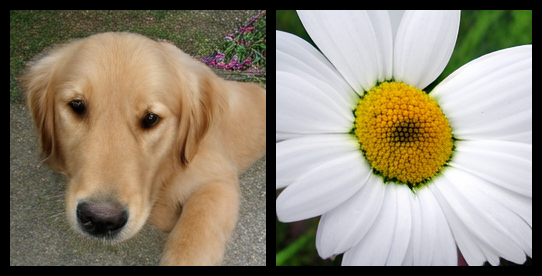

In [26]:
try:
    print("Starting image generation...")
    generated_images = generate_images_from_text(
        prompts=test_prompts,
        cfg=5.0,
        seed=42
    )
    
    # Create and save image grid
    grid = torchvision.utils.make_grid(generated_images, nrow=3, padding=10, normalize=True)
    pil_image = torchvision.transforms.ToPILImage()(grid)
    
    # Save results
    os.makedirs("results", exist_ok=True)
    pil_image.save("results/generated_images.png")
    
    print("Generation complete! Images saved to 'results/generated_images.png'")
    
    # Display if in notebook environment
    try:
        from IPython.display import display
        display(pil_image)
    except:
        pil_image.show()
        
except Exception as e:
    print(f"Generation error: {e}")
    import traceback
    traceback.print_exc()